In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from statsmodels.tsa.stattools import adfuller

In [3]:
dataset_filepath_1= dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/LG_CHEM.csv'

# 데이터 준비 (close 만 사용)

In [4]:
df_1 = pd.read_csv(dataset_filepath_1, index_col='Date', parse_dates=True)
ts_1 = df_1['Close']
ts_1.head()

Date
2001-04-26    13000.0
2001-04-27    12700.0
2001-04-30    12800.0
2001-05-01        NaN
2001-05-02    13000.0
Name: Close, dtype: float64

# 전처리 수행(결측치 처리 및 로그 변환)

In [5]:
# 결측치 처리
ts_1=ts_1.interpolate(method='time')
ts_1[ts_1.isna()]

Series([], Name: Close, dtype: float64)

In [6]:
# 로그 변환
ts_log_1 = np.log(ts_1)

# 시계열 안정성 분석

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열 
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean') 
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [8]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다. 
    dftest = adfuller(timeseries, autolag='AIC')
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다. 
    print('Results of Dickey-Fuller Test:') 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) 
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

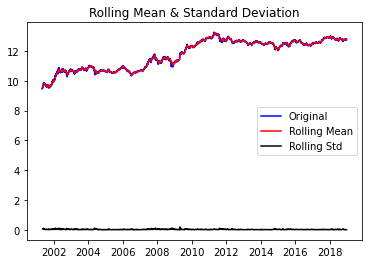

Results of Dickey-Fuller Test:
Test Statistic                   -1.972222
p-value                           0.298884
#Lags Used                        6.000000
Number of Observations Used    4437.000000
Critical Value (1%)              -3.431825
Critical Value (5%)              -2.862192
Critical Value (10%)             -2.567117
dtype: float64


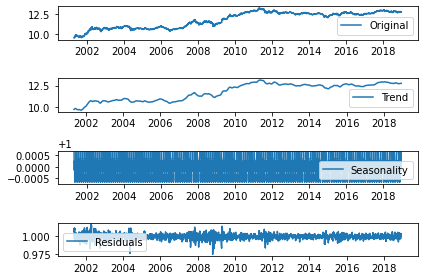

In [9]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_log_1, window=12)

#정량적 Augmented Dicky-Fuller Test

augmented_dickey_fuller_test(ts_log_1)

#시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_1, model='multiplicative', period = 30 )
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log_1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [10]:
#안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.867292e+01
p-value                        2.044142e-30
#Lags Used                     2.400000e+01
Number of Observations Used    4.389000e+03
Critical Value (1%)           -3.431841e+00
Critical Value (5%)           -2.862199e+00
Critical Value (10%)          -2.567121e+00
dtype: float64


# 학습,테스트 데이터 셋 분리

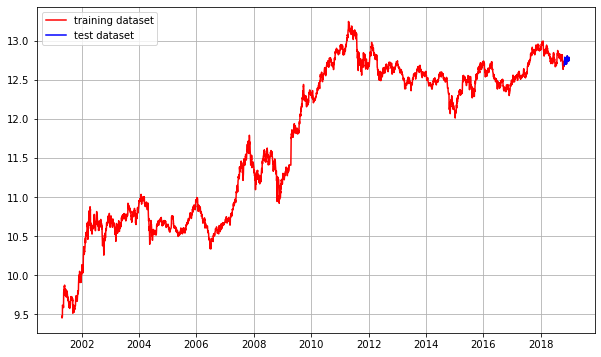

In [11]:
train_data, test_data = ts_log_1[:int(len(ts_log_1)*0.99)], ts_log_1[int(len(ts_log_1)*0.99):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_1, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log_1를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 적정 ARIMA 모수 찾기

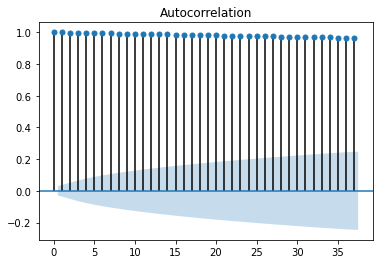

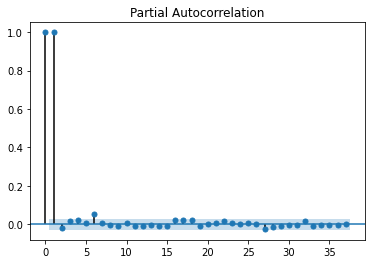

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -29.883209
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    4437.000000
Critical Value (1%)              -3.431825
Critical Value (5%)              -2.862192
Critical Value (10%)             -2.567117
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.143494
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4410.000000
Critical Value (1%)              -3.431834
Critical Value (5%)              -2.862196
Critical Value (10%)             -2.567119
dtype: float64


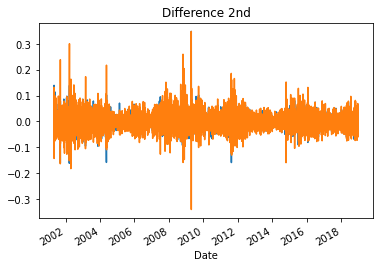

In [13]:
# 1차 차분 구하기
diff_1 = ts_log_1.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# ARIMA 모델 훈련과 테스트

In [14]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4398
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9655.044
Method:                       css-mle   S.D. of innovations              0.027
Date:                Tue, 18 Aug 2020   AIC                         -19304.088
Time:                        09:19:42   BIC                         -19284.921
Sample:                             1   HQIC                        -19297.326
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.764      0.078   -8.23e-05       0.002
ar.L1.D.Close     0.0341      0.015      2.260      0.024       0.005       0.064
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


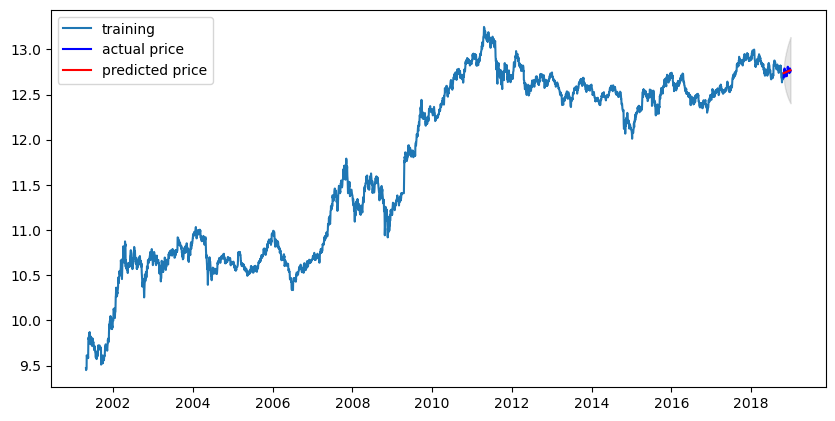

In [15]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  60842613.83394991
MAE:  6118.973470070614
RMSE:  7800.16755165874
MAPE: 1.78%


# 결과 및 총평

코로나바이러스가 주가에 영향을 준 기간을 제외하고 데이터를 학습시켰다.

또 이 경우에는 예외적으로 테스트 데이터의 구간을 매우 짧게 설정하였고, 1% 오차율의 우수한 성능을 보였다.